# Hyperparameter Tuning using HyperDrive

### Libraries


In [1]:
# AzureML
from azureml.core import Workspace, Dataset, Experiment, Run
from azureml.train.hyperdrive import HyperDriveRun
from azureml.widgets import RunDetails
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice
from azureml.train.dnn import TensorFlow

# Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, TimeDistributed, GRU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os


## Dataset

### Overview

The dataset used for this experiment will be an opensource univariate dataset provided by the San Francisco International Airport (SFO). The dataset contains all informations on Monthly Passenger Traffic at the airport since July 2005.

More informations about the dataset can be found here : https://data.sfgov.org/Transportation/Air-Traffic-Passenger-Statistics/rkru-6vcg

The main goal of the experiment will be to see the impact of the COVID19 on passenger traffic at SFO. We are going to compare forecast data train on the dataset before Covid and compare it to actual data from march 2020 to September 2020.

The dataset was already prepared and upload to Azure ML in the AutoML notebook so we only have to load it.

In [2]:
ws = Workspace.from_config()
experiment_name = 'SFO-Traffic-Predictions'

experiment=Experiment(ws, experiment_name)

# Load the dataset already upload in the autoML notebook
dataset_prepared = Dataset.get_by_name(ws, name='SFO Air Traffic cleaned')

df = dataset_prepared.to_pandas_dataframe()
df = df.set_index('date', inplace=False)

In [3]:
# Check the DataFrame
df.tail()


,Passenger Count
date,
2019-10-01,4824559
2019-11-01,4370463
2019-12-01,4720992
2020-01-01,4241751
2020-02-01,3742224


## Compute Configuration

In [4]:
# Choose a name for your CPU cluster
amlcompute_cluster_name = "AMLTraining"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',# for GPU, use "STANDARD_NC6"
                                                           #vm_priority = 'lowpriority', # optional
                                                           max_nodes=4,
                                                          min_node_count = 0, timeout_in_minutes = 10)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Model exploration

In this notebook we will try to forecast with 2 different model, a simple DNN and a a LSTM implementation. Before creating the script for the hyperdrive run, let's try a base run with those 2 models.

In [5]:
# Prepare data for NN training

# Preprocessing

def dnn_2d(df, look_back):
    X,Y =[], []
    for i in range(len(df)-look_back):
        d=i+look_back
        X.append(df[i:d,0])
        Y.append(df[d,0])
    return np.array(X),np.array(Y)

train_size = 160

train, test = df.values[0:train_size,:], df.values[train_size:,:]

look_back = 12

def model_dnn(look_back):
    model = Sequential()
    model.add(Dense(units=32, input_dim=look_back, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae',tf.metrics.RootMeanSquaredError()])

    return model

# Training DNN

model = model_dnn(look_back)

X_train,y_train = dnn_2d(train,look_back)

X_test,y_test = dnn_2d(test,look_back)

history = model.fit([X_train], [y_train], epochs = 100, batch_size=32, verbose=0,
                    validation_data=([X_test],[y_test]),
#                     callbacks=[EarlyStopping(monitor='val_loss',patience=10)],
                    shuffle=False)

print('Done')


Done


Train Root Mean Squared Error(RMSE): 320.00; Train Mean Absolute Error(MAE) : 137631.50 
Val Root Mean Squared Error(RMSE): 505.98; Test Mean Absolute Error(MAE) : 284731.84 


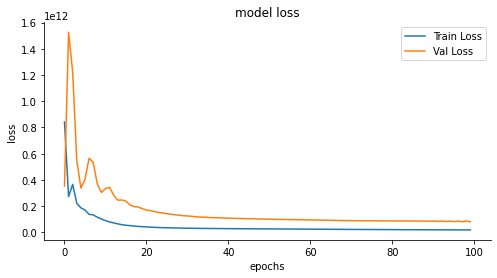

In [6]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    sns.despine(top=True)
    plt.show()
    
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Val Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


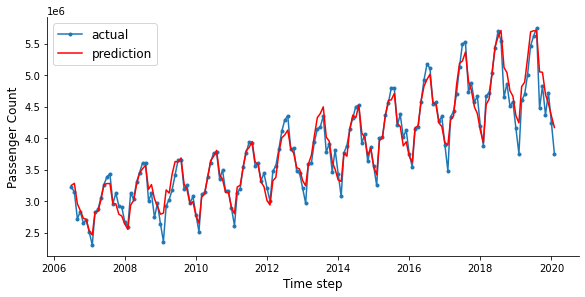

In [7]:

def prediction_plot(y_test, test_predict):
    len_prediction=df.index[look_back:]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, y_test[:], marker='.', label="actual")    
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.ylabel('Passenger Count', size=12)
    plt.xlabel('Time step', size=12)
    plt.legend(fontsize=12)    
    plt.show()

Xa,ya = dnn_2d(df.values,look_back)

test_predict = model.predict(Xa)

prediction_plot(ya, test_predict)


In [8]:
# LSTM

def lstm_3d(df, look_back):
    X, Y =[], []
    for i in range(len(df)-look_back):
        d=i+look_back
        X.append(df[i:d,])
        Y.append(df[d,])
    return np.array(X), np.array(Y)


#create numpy.ndarray
df_arr= df.values
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

train_size = 160
test_size = len(df_arr)-train_size
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 12
trainX, trainY = lstm_3d(train, look_back)
testX, testY = lstm_3d(test, look_back)
# reshape input to be [samples, time steps, features]
# print(trainY.shape)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# print(trainX.shape)

def model_lstm(look_back):
    model=Sequential()
#     model.add(LSTM(100, input_shape=(1, look_back), activation='relu'))
#     model.add(Dense(1))
    
    model.add(LSTM(64, activation='relu', input_shape=(1,look_back)))
    #lstm.add(LSTM(32, activation='relu', input_shape=(32,1)))
    model.add(Dense(10))
    model.add(Dropout(0.3))
    #lstm.add(Dense(10))
    #lstm.add(Dropout(0.3))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])

    
    return model


model=model_lstm(look_back)
history = model.fit(trainX, trainY, epochs=100, batch_size=30, validation_data=(testX, testY),
#                     callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    verbose=0, shuffle=False)

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions

train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)

print('Done')


### Hyperparameters
# layers
# nodes
# batch_size
# Model_type
# epochs
# look_back


Done


Train Root Mean Squared Error(RMSE): 150141.50; Train Mean Absolute Error(MAE) : 122971.81 
Test Root Mean Squared Error(RMSE): 213858.33; Test Mean Absolute Error(MAE) : 206354.00 


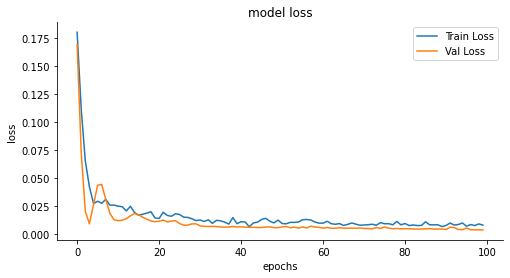

In [9]:
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(trainY[:,0], train_predict[:,0])),(mean_absolute_error(trainY[:,0], train_predict[:,0]))))
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(testY[:,0], test_predict[:,0])),(mean_absolute_error(testY[:,0], test_predict[:,0]))))


model_loss(history)

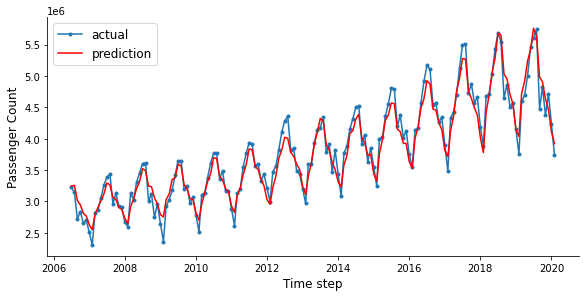

In [10]:
# Plot the prediction against the actual data
Xa,ya = lstm_3d(df_arr,look_back)
Xa = np.reshape(Xa, (Xa.shape[0], 1, Xa.shape[1]))

test_predict = model.predict(Xa)
ya = scaler.inverse_transform(ya)

test_predict = scaler.inverse_transform(test_predict)


prediction_plot(ya, test_predict)

## Hyperdrive Configuration

Explain the model you are using and the reason for chosing the different hyperparameters, termination policy and config settings.

During the hyperdrive run, we will test 2 different algoritm and 6 hyperparameters.

Models:
- Simple DNN
- LSTM

Hyperparameters:
- epochs
- layers
- neurons
- look back window
- dropout
- batch size

Early termination policy:
- Bandit with a slack_factor of 0.1

The dataset will also be a script parameters.

We will use the TensorFlow estimator object with the 'train.py' script and the pip_packages dependencies.

Finally, the Hyperdrive config will try to minimize the MAE during a max of 40 runs.


In [11]:
# Create an early termination policy. This is not required if using Bayesian sampling.
early_termination_policy = BanditPolicy(slack_factor=0.1, evaluation_interval=1, delay_evaluation=5)

# Create the different params that will be using during training

script_params = {
    '--dataset':'SFO Air Traffic cleaned',   
}

param_sampling = RandomParameterSampling(
    {
        '--n_epochs': choice(100,200,500),
        '--model_type': choice('DNN','LSTM'),
        '--n_layers': choice(0,1,2),
        '--n_neurons': choice(16,64,128),
        '--look_back': choice(6,12,15),
        '--dropout': choice(0.0,0.2,0.3),
        '--batch_size': choice(16,64,128)
    }

)

# Create your estimator and hyperdrive config
estimator = TensorFlow(source_directory='.',
                 script_params=script_params,
                 compute_target=compute_target, 
                 entry_script='train.py',
                 pip_packages= [                            
                            "numpy",
                            "pandas",
                            "scikit-learn",
                            "matplotlib",
                            "seaborn",
                            "scikit-learn"
                 ])

hyperdrive_run_config = HyperDriveConfig(estimator=estimator,
                                         hyperparameter_sampling=param_sampling,
                                         policy=early_termination_policy,
                                         primary_metric_name='MAE_val',
                                         primary_metric_goal=PrimaryMetricGoal.MINIMIZE,
                                         max_total_runs=40,
                                         max_concurrent_runs=4,
                                         max_duration_minutes= 180)

'TensorFlow' estimator is deprecated. Please use 'ScriptRunConfig' from 'azureml.core.script_run_config' with your own defined environment or one of the Azure ML TensorFlow curated environments.
framework_version is not specified, defaulting to version 1.13.


In [12]:
# Submit the experiment
TRAIN = False

if TRAIN:
    hyperdrive_run = experiment.submit(hyperdrive_run_config)
    hyperdrive_run.wait_for_completion(show_output=True)
    
# If we already did the training, we can get our run by passing the run_id.
else:
    hyperdrive_run = HyperDriveRun(experiment, 'HD_6dfb0202-8e37-4b4e-8652-b913e9c8f7b6')


## Run Details

In the cell below, use the `RunDetails` widget to show the different experiments.

In [13]:
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

## Best Model

In the cell below, we get the best model from the hyperdrive experiments and display all the properties of the model.

In [14]:
best_run_hdr = hyperdrive_run.get_best_run_by_primary_metric()

print('MAE of the best hyperdrive run : {} \n'.format(best_run_hdr.get_metrics()['MAE_val']))

list_hyper = best_run_hdr.get_details()['runDefinition']['arguments']

print('Choice of HyperParameters:')
for i in range(0,len(list_hyper),2):
    print(list_hyper[i]+' : '+list_hyper[i+1])
    


MAE of the best hyperdrive run : 106673.0 

Choice of HyperParameters:
--dataset : SFO Air Traffic cleaned
--batch_size : 16
--dropout : 0.2
--look_back : 15
--model_type : DNN
--n_epochs : 100
--n_layers : 2
--n_neurons : 128


In [17]:
# Save the Keras model

os.makedirs('outputs', exist_ok=True)

best_run_hdr.download_file('outputs/'+best_run_hdr.id, output_file_path='./outputs/')

!ls ./outputs/

AutoML	HD_6dfb0202-8e37-4b4e-8652-b913e9c8f7b6_9


In [18]:
best_model = load_model('outputs/'+best_run_hdr.id)

best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 35,201
Trainable params: 35,201
Non-trainable params: 0
_________________________________________________________________


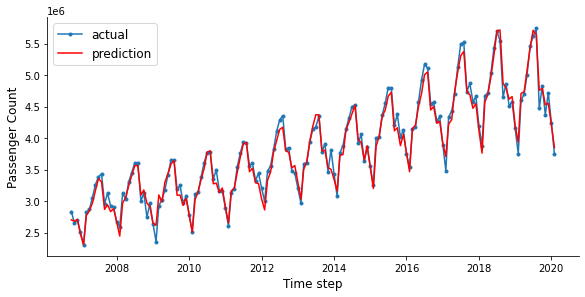

In [20]:
# Check the actual vs predicted of the best model

def prediction_plot(df,y_test, test_predict,look_back):
    len_prediction=df.index[look_back:]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, y_test[:], marker='.', label="actual")    
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.ylabel('Passenger Count', size=12)
    plt.xlabel('Time step', size=12)
    plt.legend(fontsize=12)    
    plt.show()
    return

X,y = dnn_2d(df.values,15)

test_predict = best_model.predict(X)

prediction_plot(df,y, test_predict,15)

In [22]:
# post Covid prediction

df_covid = Dataset.get_by_name(ws, name='SFO Air Traffic covid')


df_covid = df_covid.to_pandas_dataframe()
df_covid = df_covid.set_index('date', inplace=False)

df1 = df.copy()

for p in range(len(df_covid)):    
    
    X_covid,y_covid = dnn_2d(df1.values[-16:],15)
    prediction = best_model.predict(X_covid)
#     print(prediction[0][0])
    df1.loc[df_covid.index[p]] = prediction[0][0]

print(df1.tail(12))


            Passenger Count
date                       
2019-10-01       4824559.00
2019-11-01       4370463.00
2019-12-01       4720992.00
2020-01-01       4241751.00
2020-02-01       3742224.00
2020-03-01       3848897.75
2020-04-01       4770984.00
2020-05-01       4569545.00
2020-06-01       4882662.50
2020-07-01       5288124.00
2020-08-01       5414745.00
2020-09-01       5459186.00


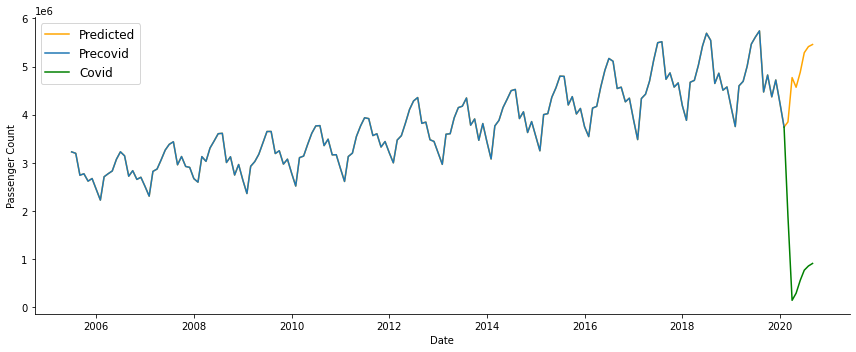

In [23]:
# Now we can plot the impact of COVID19 on the SFO Air Traffic passenger

date = pd.to_datetime("2020-02-01", format = '%Y-%m-%d')

df_covid = df_covid.append(pd.DataFrame({'Passenger Count': 3742224}, index=[date]))

df_covid.sort_index(inplace=True)

f, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(df1, label = 'Predicted', color = 'orange')
ax.plot(df, label = 'Precovid')
ax.plot(df_covid, label = 'Covid', color = 'green')
ax.set_xlabel("Date")
ax.set_ylabel("Passenger Count")
ax.legend()
# plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=12)
sns.despine(top=True)


## Model Deployment (Done in the autoML notebook)

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

In the cell below, register the model, create an inference config and deploy the model as a web service.

In [ ]:
# model = best_run_hdr.register_model(model_name='SFO-Passenger-NN-model', model_path='outputs/model')


In the cell below, send a request to the web service you deployed to test it.

In the cell below, print the logs of the web service and delete the service